In [1]:
import pandas as pd
import numpy as np
import os
#Read the data from GitHub directly
url = "https://github.com/renatoquiliche/PaperCienciaDados-PunoPeru/blob/main/Databases/peru_2019.csv?raw=true"

data_puno = pd.read_csv(url)

In [2]:
# Set the random seed for reproductible results
np.random.seed(0)

Y = data_puno["disasters_risk"]

In [4]:
from preprocessing import preprocessing
x = preprocessing(data_puno, umbral=0.02)

Old data dimension (1106, 86)
Features removed : 13
New data dimension (1106, 73)


In [6]:
# Init the grid search cross-validation on RFC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score, roc_curve
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# I define here the NPV metric
def neg_pred_value(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted)
    if (cm[1][0]+cm[0][0])==0:
        neg_pred_value=0
    else:
        neg_pred_value = cm[0][0]/(cm[1][0]+cm[0][0])
    return neg_pred_value

In [7]:
[1e-3,1e-2,1e-1,1,1e1,1e2,1e3]

[0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0]

In [66]:
from sklearn.neural_network import MLPClassifier

def RFCexperiments(K_folds, Repeats, n_iter):
    # Cross-validation method
    cv = RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=Repeats, random_state=0)
    
    # Hyperparameter grid for RFC
    param_grid = {'hidden_layer_sizes': [(100,10),(110,10), (120,10), (130,10)],
                  'solver': ['adam'],
                  'activation': ['identity', 'tanh'],
                  'alpha': [8,9,10,11,12],
                  'learning_rate_init': [0.01],
                  'max_iter': [1000,1200],
                  'beta_1': [0.9],
                  'beta_2': [0.999]}
    
    # I define the model here
    MLP = MLPClassifier(random_state=0)
    scoring = {"AUC": "roc_auc"
               , "Accuracy": make_scorer(accuracy_score)
               , "F1-Score": "f1"
               , "MCC": make_scorer(matthews_corrcoef)
               , "NPV": make_scorer(neg_pred_value)}
    
    #Test CV
    search_ddnn = RandomizedSearchCV(random_state=0, estimator=MLP, param_distributions=param_grid
                                     , scoring=scoring, cv=cv, n_jobs=-1, refit="MCC", verbose=10, n_iter=n_iter)
    results = search_ddnn.fit(x, Y)
    return results

In [67]:
import time
start = time.time()

K = 10
Repeats = 1
n_iter = 200
RFC_results =  RFCexperiments(K, Repeats, n_iter)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")

C:\Users\xx-re\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 80 is smaller than n_iter=200. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 80 candidates, totalling 800 fits
Training time:  57.9514274597168  seconds


In [43]:
RFC_results.best_score_

0.5578231029879376

<AxesSubplot: >

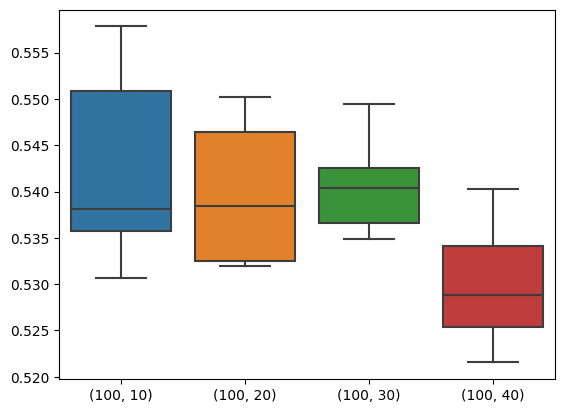

In [65]:
import seaborn as sns
sns.boxplot(x=RFC_results.cv_results_['param_'+'hidden_layer_sizes'], y=RFC_results.cv_results_['mean_test_MCC'])